# Week - 8 - Deep Neural Nets and Text - Training Models
**Ying Sun**

**Note: I conducted this homework in Google colab and only includes my answers to exercises.**


In this week we will be introduced to using Deep Neural Networks to work with text. We have already seen some uses of neural networks for text in our classification HW, where we used a simple neural network to classify text - it performs quite well, but they can come up short in more sophisticated classification tasks, such as in predicting intent. We have also seen neural nets in the form of word embeddings such as Word2Vec - and while they certainly work well, they have some drawbacks, such as dealing with words with multiple meanings.

BERT, which is a language model built using bidirectional encoders, allows us to have a powerful pre-trained model which we can then use to perform our own tasks based on the data we are analysing.

In this notebook we will use huggingface/transformers, which is a python package which allows for an easy interface to use pre-trained BERT models. It is built using Tensorflow and PyTorch, two computational graph packages which are built specifically for creating powerful neural networks. We will also be introducing Keras, which allows us to easily build Neural Networks in an abstracted way. Keras is a popular way to understand how we can stack layers to create such Neural Networks, though to reach state-of-the-art results we will stick with using BERT and similar models.

To demonstrate this, we will use the Corpus of Linguistic Acceptability. We will also be using BERT by learning how to extract embeddings from such a model and use it to semantically probe sentences. There are a bunch of new packages and methods we will be using so be sure to update lucem_illud_2020.

Note that this notebook is different to take advantage of the GPU here. We only run the GPU heavy tasks here, where we need models to be fine-tuned.

The first section contains the CoLA classification task, the second contains training a model on Trump tweets, and the last bit has us training a model on US and UK blog posts.

To switch on your GPU, go to edit -> notebook settings -> hardware accelerator -> enable GPU.

# <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that estimate a deep classification model with Keras (and LSTM) and also BERT in order to predict pre-established data labels relevant to your final project (as for week 3's homework). Which works better? Are the errors the same or different?

<span style="color:red">***Stretch***</span>: <span style="color:red">Now alter the neural network by stacking network layers, adjusting the embedding dimension, compare its performance with your model above, and interpret why it might be different.

In this exercise, I continue to use the dataset I used in hw3

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [3]:
!pip install transformers

     |████████████████████████████████| 501kB 4.8MB/s 
     |████████████████████████████████| 3.7MB 57.0MB/s 
     |████████████████████████████████| 870kB 53.3MB/s 
     |████████████████████████████████| 1.0MB 51.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=25f9482d6bda2c7de88cb6e0bc30023682e8d45008c263ec3fa8eb02f74fb640
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [1]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load the data I used in hw3
review_raw = pd.read_csv("review.csv")
review_raw.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
# form the analysis dataset
review = review_raw[['Review Text','Rating','Class Name','Age']]
review.head()

,Review Text,Rating,Class Name,Age
0,Absolutely wonderful - silky and sexy and comf...,4,Intimates,33
1,Love this dress! it's sooo pretty. i happene...,5,Dresses,34
2,I had such high hopes for this dress and reall...,3,Dresses,60
3,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,50
4,This shirt is very flattering to all due to th...,5,Blouses,47


In [5]:
# fill NA values by space
review['Review Text'] = review['Review Text'].fillna('')

Then we need to add a column "category" to represent the positive or negative reviews based on the rating. If the rating is 4 or higher, we can regard it as a positive review. If the rating is 2 or lower, we can regard it as a negative review. I plan to implement binary classification here so I only retain the record with negative or positive sentiment.

In [6]:
b_df = review[review['Rating'] != 3]
b_df['label'] = np.where(b_df['Rating']>=4, 1, 0)
b_df.head()

,Review Text,Rating,Class Name,Age,label
0,Absolutely wonderful - silky and sexy and comf...,4,Intimates,33,1
1,Love this dress! it's sooo pretty. i happene...,5,Dresses,34,1
3,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,50,1
4,This shirt is very flattering to all due to th...,5,Blouses,47,1
5,"I love tracy reese dresses, but this one is no...",2,Dresses,49,0


In [0]:
b_df.shape

(20615, 5)

Here we use roughly 80% of all the data in training model and 20% for testing.

In [0]:
train_df = b_df[:16500]
train_df.shape

(16500, 5)

In [0]:
# Create sentence and label lists
sentences = train_df['Review Text'].values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = train_df.label.values

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'absolutely', 'wonderful', '-', 'silky', 'and', 'sexy', 'and', 'comfortable', '[SEP]']


In [0]:
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [0]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

In [0]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [0]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2020, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.1)

After preprocessing, we can move to the deep neural nets.

In [0]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

In [0]:
vocab_in_size = tokenizer.vocab_size
embedding_dim = 32
unit = 100
no_labels = len(np.unique(train_labels))
batch_size = 32

In [0]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm.add(LSTM(unit))
model_lstm.add(Dense(no_labels, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 128, 32)           976704    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 1,030,106
Trainable params: 1,030,106
Non-trainable params: 0
_________________________________________________________________


In [0]:
history_lstm = model_lstm.fit(train_inputs, train_labels, 
                              epochs=10,batch_size=batch_size)

Epoch 1/10
14850/14850 [==============================] - 103s 7ms/step - loss: 0.3686 - acc: 0.8821
Epoch 2/10
14850/14850 [==============================] - 101s 7ms/step - loss: 0.3588 - acc: 0.8838
Epoch 3/10
14850/14850 [==============================] - 102s 7ms/step - loss: 0.3387 - acc: 0.8831
Epoch 4/10
14850/14850 [==============================] - 101s 7ms/step - loss: 0.3467 - acc: 0.8834
Epoch 5/10
14850/14850 [==============================] - 102s 7ms/step - loss: 0.3429 - acc: 0.8837
Epoch 6/10
14850/14850 [==============================] - 104s 7ms/step - loss: 0.3363 - acc: 0.8838
Epoch 7/10
14850/14850 [==============================] - 101s 7ms/step - loss: 0.3240 - acc: 0.8843
Epoch 8/10
14850/14850 [==============================] - 100s 7ms/step - loss: 0.3258 - acc: 0.8840
Epoch 9/10
14850/14850 [==============================] - 99s 7ms/step - loss: 0.2116 - acc: 0.9086
Epoch 10/10
14850/14850 [==============================] - 98s 7ms/step - loss: 0.1500 - acc

From the above results, we can see that the accuracy of this model is not bad, it hovers around 94%. Then we can implement BERT to see the performance.

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [0]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

In [0]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [0]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    465.    Elapsed: 0:00:30.
  Batch    80  of    465.    Elapsed: 0:01:00.
  Batch   120  of    465.    Elapsed: 0:01:31.
  Batch   160  of    465.    Elapsed: 0:02:01.
  Batch   200  of    465.    Elapsed: 0:02:32.
  Batch   240  of    465.    Elapsed: 0:03:04.
  Batch   280  of    465.    Elapsed: 0:03:36.
  Batch   320  of    465.    Elapsed: 0:04:08.
  Batch   360  of    465.    Elapsed: 0:04:39.
  Batch   400  of    465.    Elapsed: 0:05:11.
  Batch   440  of    465.    Elapsed: 0:05:43.

  Average training loss: 0.17
  Training epcoh took: 0:06:02

Running Validation...
  Accuracy: 0.93
  Validation took: 0:00:13

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    465.    Elapsed: 0:00:32.
  Batch    80  of    465.    Elapsed: 0:01:03.
  Batch   120  of    465.    Elapsed: 0:01:35.
  Batch   160  of    465.    Elapsed: 0:02:07.
  Batch   200  of    465.    Elapsed: 0:02:39.
  Batch   240  of    465.    Elap

## Training Evaluation

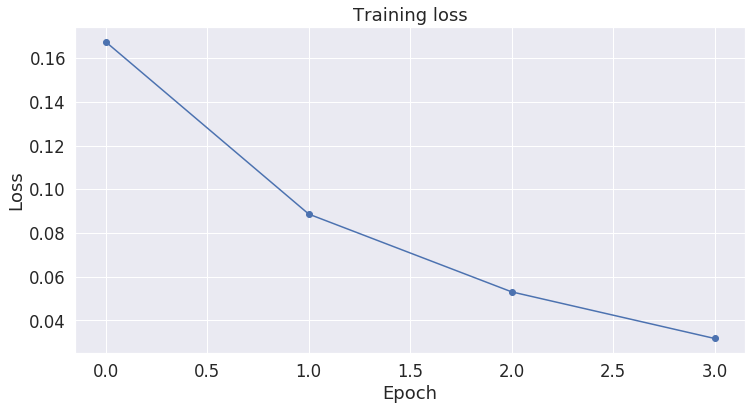

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Holdout Set

In [0]:
test_df = b_df[16500:]
test_df.shape

(4115, 5)

In [0]:
test_df.head()

,Review Text,Rating,Class Name,Age,label
18821,I love the muted coloring! this top is generou...,4,Blouses,43,1
18822,I thought this top was so cute but when i trie...,1,Blouses,37,0
18823,I loved the color of the top and the faded loo...,4,Blouses,23,1
18824,These truly are tights and not leggings. they ...,5,Legwear,44,1
18825,I love this top! it fits perfect and is of gre...,5,Blouses,45,1


In [0]:
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))

# Create sentence and label lists
sentences = test_df['Review Text'].values
labels = test_df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 4,115



In [0]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 4,115 test sentences...
    DONE.


In [0]:
print('Positive samples: %d of %d (%.2f%%)' % (test_df.label.sum(), len(test_df.label), (test_df.label.sum() / len(test_df.label) * 100.0)))

Positive samples: 3637 of 4115 (88.38%)


In [0]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
    matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [0]:
matthews_set

[0.6753002216523571,
 0.6831300510639733,
 0.8783100656536799,
 1.0,
 1.0,
 0.0,
 0.8027729719194864,
 0.5673665146135802,
 0.8783100656536799,
 0.6050580452280905,
 0.7867957924694432,
 0.0,
 0.7141684885491869,
 1.0,
 0.52678658400752,
 1.0,
 0.0,
 0.8509629433967631,
 0.8027729719194864,
 0.7141684885491869,
 0.8509629433967631,
 0.762962962962963,
 0.8509629433967631,
 0.7948717948717948,
 1.0,
 1.0,
 0.762962962962963,
 0.8509629433967631,
 0.8958064164776167,
 1.0,
 0.762962962962963,
 0.4666666666666667,
 0.6,
 0.7142857142857143,
 0.632183908045977,
 0.8171428571428572,
 1.0,
 0.9078412990032037,
 0.8027729719194864,
 1.0,
 0.8027729719194864,
 1.0,
 0.4666666666666667,
 0.6753002216523571,
 0.7453559924999299,
 0.9078412990032037,
 0.8320502943378436,
 0.8333333333333334,
 0.7142857142857143,
 0.7142857142857143,
 0.647150228929434,
 0.6831300510639733,
 0.8027729719194864,
 0.0,
 0.8027729719194864,
 0.8509629433967631,
 0.8509629433967631,
 0.9078412990032037,
 0.46666666666

In [0]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.787


In [0]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

From the result above, we can see that's pretty good performance.

# <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, use the pipeline functions and the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. You have used similar, but often weaker versions in previous weeks. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

In [17]:
import torch

In [7]:
b_df.shape

(20615, 5)

In [8]:
from transformers import BertModel

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [10]:
b_df.head()

,Review Text,Rating,Class Name,Age,label
0,Absolutely wonderful - silky and sexy and comf...,4,Intimates,33,1
1,Love this dress! it's sooo pretty. i happene...,5,Dresses,34,1
3,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,50,1
4,This shirt is very flattering to all due to th...,5,Blouses,47,1
5,"I love tracy reese dresses, but this one is no...",2,Dresses,49,0


In [11]:
text = b_df['Review Text'][0]
text

'Absolutely wonderful - silky and sexy and comfortable'

In [12]:
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[CLS]', 'absolutely', 'wonderful', '-', 'silky', 'and', 'sexy', 'and', 'comfortable', '[SEP]']


In [13]:
# see the vocabulary looks like
list(tokenizer.vocab.keys())[6000:6030]

['peninsula',
 'adults',
 'novels',
 'emerged',
 'vienna',
 'metro',
 'debuted',
 'shoes',
 'tamil',
 'songwriter',
 'meets',
 'prove',
 'beating',
 'instance',
 'heaven',
 'scared',
 'sending',
 'marks',
 'artistic',
 'passage',
 'superior',
 '03',
 'significantly',
 'shopping',
 '##tive',
 'retained',
 '##izing',
 'malaysia',
 'technique',
 'cheeks']

In [14]:
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

In [15]:
# segment id
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [18]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [20]:
# Load pre-trained model (weights)
model_embedding = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model_embedding.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [21]:
output = model_embedding(tokens_tensor)
len(output[0][0][0]), len(output[1][0])

(768, 768)

In [22]:
word_embeddings, sentence_embedding = output

In [23]:
len(word_embeddings[0])

10

In [24]:
word_embeddings[0]

tensor([[-0.4399, -0.0191, -0.0617,  ..., -0.3785,  0.1435,  0.4821],
        [ 0.6304,  0.1536,  0.2274,  ..., -0.3958,  0.9708,  0.6290],
        [ 0.6038,  0.5120,  0.3658,  ..., -0.7298,  0.4188, -0.3061],
        ...,
        [-0.9268, -0.4823,  0.4026,  ..., -0.2851,  0.4595,  0.5096],
        [-0.7741, -0.5284,  0.2177,  ..., -0.5207,  0.3757, -0.3708],
        [ 0.7537,  0.0132, -0.3186,  ..., -0.1667, -0.6352, -0.1745]],
       grad_fn=<SelectBackward>)

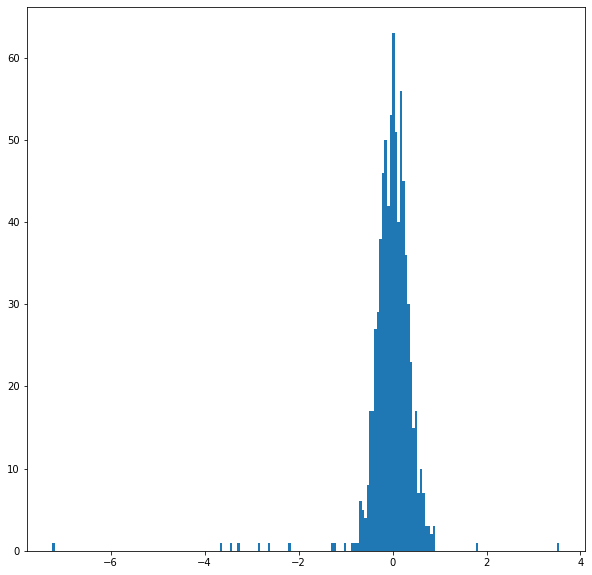

In [25]:
vec = word_embeddings[0][0]
vec = vec.detach().numpy()
# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

These values are groupd by layer.

### Word Vectors

In [26]:
token_vecs = []
# For each token in the sentence...
for embedding in word_embeddings[0]:
    cat_vec = embedding.detach().numpy()
    # Use `cat_vec` to represent `token`.
    token_vecs.append(cat_vec)

In [27]:
token_vecs

[array([-4.39877272e-01, -1.90802664e-02, -6.16667457e-02,  6.03222772e-02,
        -4.18127298e-01, -2.64296681e-01, -1.87311396e-01,  2.07460880e-01,
         2.89250445e-02, -3.17205563e-02, -1.32442310e-01,  2.09557757e-01,
         5.20663440e-01,  5.59812963e-01, -9.67808068e-02,  1.42375648e-01,
        -1.80406988e-01,  3.62244427e-01,  9.67378020e-02, -2.95396090e-01,
         5.54107502e-02, -1.74445540e-01, -1.98907390e-01, -1.36980474e-01,
         3.77720445e-02,  9.75560099e-02, -1.29530638e-01,  7.10966140e-02,
         3.49142075e-01,  3.04462194e-01,  1.29554555e-01, -1.23081461e-01,
        -1.34923130e-01, -3.55803162e-01,  3.13375741e-01, -2.52043128e-01,
         2.97488153e-01, -3.14916313e-01, -3.62309128e-01, -4.68669713e-01,
        -1.26954794e-01,  4.75697070e-02,  3.11124325e-01, -4.70018610e-02,
        -1.30449235e-03, -4.45340872e-02, -2.85827136e+00,  4.55799662e-02,
        -2.00929165e-01, -5.02035320e-02,  1.85074016e-01, -3.43539923e-01,
         2.1

### Sentence Vectors

In [28]:
sentence_embedding_0 = sentence_embedding.detach().numpy()[0]
sentence_embedding_1 = np.mean(token_vecs, axis=0)
len(sentence_embedding_0), len(sentence_embedding_1)

(768, 768)

In [29]:
for i, token_str in enumerate(tokenized_text):
    print(i, token_str)

0 [CLS]
1 absolutely
2 wonderful
3 -
4 silky
5 and
6 sexy
7 and
8 comfortable
9 [SEP]


In [30]:
from scipy.spatial.distance import cosine

In [31]:
1 - cosine(sentence_embedding_0, sentence_embedding_1)

0.031909264624118805

In [32]:
def word_vector(text, word_id, model, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings, sentence_embeddings = model(tokens_tensor)   
    vector = word_embeddings[0][word_id].detach().numpy()
    return vector

In [33]:
word_4 = word_vector(text, 5, model_embedding, tokenizer)
word_5 = word_vector(text, 4, model_embedding, tokenizer)
word_6 = word_vector(text, 6, model_embedding, tokenizer)

In [34]:
def sentence_vector(text, model, tokenizer, method="average"):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings, sentence_embeddings = model(tokens_tensor)
    token_vecs = []
    
    for embedding in word_embeddings[0]:
        cat_vec = embedding.detach().numpy()
        token_vecs.append(cat_vec)
        
    if method == "average":
        sentence_embedding = np.mean(token_vecs, axis=0)
    if method == "model":
        sentence_embedding = sentence_embeddings
    # do something
    return sentence_embedding

In [35]:
sen_vec_0 = sentence_vector(text, model_embedding, tokenizer)
sen_vec_1 = sentence_vector(text, model_embedding, tokenizer, method="model")

In [36]:
sen_vec_0

array([-4.66597006e-02, -1.14628233e-01,  2.25870922e-01,  1.92374006e-01,
        1.38262779e-01, -1.04091883e-01, -4.56632860e-02, -5.65509796e-02,
        3.37098539e-02, -1.43111467e-01,  1.27343804e-01, -2.08311826e-01,
        2.03987315e-01,  5.24847388e-01, -7.77174979e-02,  5.64874351e-01,
        2.41172507e-01, -1.10864624e-01, -3.92622948e-01,  1.28040165e-01,
        3.05907071e-01, -3.20705205e-01, -2.15200692e-01,  2.22033545e-01,
        6.30764604e-01,  2.42748093e-02, -9.63131189e-02,  1.93873912e-01,
        1.26300100e-02, -2.53424555e-01,  4.81704950e-01, -3.29156891e-02,
       -1.26535743e-01, -2.24385768e-01, -4.20149952e-01, -4.65344012e-01,
       -3.92766371e-02, -3.26360524e-01, -4.73033249e-01,  1.14377335e-01,
       -2.69786894e-01, -2.35798761e-01, -7.26560503e-02, -9.70358774e-02,
       -1.27273515e-01, -2.15317205e-01, -2.76455224e-01, -6.26460463e-02,
       -6.96362481e-02, -3.28973442e-01, -2.17520520e-01,  1.11001711e-02,
       -2.17285901e-01, -

In [37]:
sen_vec_1

tensor([[-7.3152e-01, -1.6142e-01, -6.6025e-01,  6.9478e-01,  6.3269e-01,
          2.0186e-03,  5.9858e-01,  3.6002e-02, -3.0995e-01, -9.9944e-01,
         -1.4121e-01,  6.9023e-01,  9.2246e-01,  1.5797e-01,  8.4201e-01,
         -4.6704e-01,  9.1086e-02, -4.2290e-01,  9.7482e-02, -1.8251e-01,
          5.5152e-01,  9.9961e-01,  2.3644e-01,  1.8933e-01,  2.9118e-01,
          7.8276e-01, -4.8583e-01,  8.5905e-01,  9.1691e-01,  6.7787e-01,
         -3.5032e-01,  4.6418e-02, -9.7380e-01,  2.3026e-02, -7.2224e-01,
         -9.6038e-01,  1.2741e-01, -4.7933e-01,  2.9103e-01,  2.1464e-01,
         -8.2852e-01,  5.1502e-02,  9.9917e-01, -5.6137e-01,  8.2981e-03,
         -7.7006e-02, -9.9992e-01,  3.3902e-02, -7.8570e-01,  6.1217e-01,
          5.3885e-01,  5.8188e-01, -3.9071e-02,  3.8031e-01,  2.0052e-01,
         -1.3369e-01, -2.1647e-01,  1.0166e-01, -7.8609e-02, -4.3171e-01,
         -4.6709e-01,  1.1096e-01, -6.1312e-01, -8.1470e-01,  4.4204e-01,
          3.8159e-01,  3.8427e-02, -6.

# <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that generate a BERT-powered chatbot tuned on text related to your final project. What is interesting about this model, and how to does it compare to an untrained model? What does it reveal about the social game involved with your dataset?

In this exercise, I would like to use another dataset - trump_tweets_full.csv I used in my homework 7 which is different from the instructional notes.

In [0]:
import pandas as pd
import torch

In [0]:
df = pd.read_csv("trump_tweets_full.csv")

In [0]:
df.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,Just another Shifty Schiff leak. Isn’t there a...,02-23-2020 01:55:18,8444.0,26492,false,1.231397e+18
1,Twitter for iPhone,“The Kremlin is reportedly backing Bernie Sand...,02-23-2020 00:17:24,13784.0,53063,false,1.231372e+18
2,Twitter for iPhone,Looks like Crazy Bernie is doing well in the G...,02-22-2020 23:55:36,15341.0,71155,false,1.231367e+18
3,Twitter for iPhone,RT @mattgaetz: Zeldin is absolutely correct.Ka...,02-22-2020 22:54:18,5323.0,0,true,1.231352e+18
4,Twitter for iPhone,RT @fonzy1984: @RubinReport What about the His...,02-22-2020 22:47:57,3725.0,0,true,1.231350e+18


In [0]:
df.shape

(42982, 7)

We can only keep the first 5000 tweets for simplicity.

In [0]:
df = df[:5000]

In [0]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(df['text'], test_size=0.2)

In [0]:
train_text.head()

4810                                  KEEP AMERICA GREAT!
3589    False stories are being reported that a few Re...
2493    I don’t know what report current Director of t...
4679    ....a Nancy Pelosi/Chuck Schumer Democrat (Joh...
4361            Sleepy Joe Biden! https://t.co/oZtytImXqq
Name: text, dtype: object

In [0]:
train_text.to_frame().to_csv(r'train_text_trump', header=None, index=None, sep=' ', mode='a')

In [0]:
test_text.to_frame().to_csv(r'test_text_trump', header=None, index=None, sep=' ', mode='a')

In [0]:
torch.cuda.empty_cache()

In [0]:
!python /content/run_language_modelling.py --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=/content/train_text_trump --do_eval --eval_data_file=/content/test_text_trump --per_gpu_train_batch_size=1 --per_gpu_eval_batch_size=1

03/03/2020 06:44:48 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
03/03/2020 06:44:49 - INFO - filelock -   Lock 140311816739080 acquired on /root/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.699bbd1c449e9861456f359d6daa51bd523ac085b4b531ab0aad5a55d091e942.lock
03/03/2020 06:44:49 - INFO - transformers.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpf7ndq3le
Downloading: 100% 224/224 [00:00<00:00, 250kB/s]
03/03/2020 06:44:49 - INFO - transformers.file_utils -   storing https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json in cache at /root/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.699bbd1c449e9861456f359d6daa51bd523ac085b4b531ab0aad5a55d091e942
03/03/2020 06:44:49 - INFO

In [0]:
!python run_generation.py --model_type=gpt2 --model_name_or_path=/content/output_gpt_trump

03/03/2020 06:57:04 - INFO - transformers.tokenization_utils -   Model name '/content/output_gpt_trump' not found in model shortcut name list (gpt2, gpt2-medium, gpt2-large, gpt2-xl, distilgpt2). Assuming '/content/output_gpt_trump' is a path, a model identifier, or url to a directory containing tokenizer files.
03/03/2020 06:57:04 - INFO - transformers.tokenization_utils -   Didn't find file /content/output_gpt_trump/added_tokens.json. We won't load it.
03/03/2020 06:57:04 - INFO - transformers.tokenization_utils -   loading file /content/output_gpt_trump/vocab.json
03/03/2020 06:57:04 - INFO - transformers.tokenization_utils -   loading file /content/output_gpt_trump/merges.txt
03/03/2020 06:57:04 - INFO - transformers.tokenization_utils -   loading file None
03/03/2020 06:57:04 - INFO - transformers.tokenization_utils -   loading file /content/output_gpt_trump/special_tokens_map.json
03/03/2020 06:57:04 - INFO - transformers.tokenization_utils -   loading file /content/output_gpt_tr

In [0]:
from transformers import AutoModelWithLMHead, AutoTokenizer

In [0]:
tokenizer_trump = AutoTokenizer.from_pretrained("output_gpt_trump")
model_trump = AutoModelWithLMHead.from_pretrained("output_gpt_trump")

In [0]:
sequence = "president election is"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

president election is over."
"


In [0]:
tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

In [0]:
sequence = "president election is"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

president election is not enough. Our Party is on the path to becoming the country we desire," he said, adding that he cannot accept the result if he does not address the issue. He did offer that the government will not hold the second referendum in


It is very interesting to see that is quite contrast.

# <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that tune BERT to at least two different textual samples. These could be from different corpora, distinct time periods, separate authors, alternative publishing outlets, etc. Then compare the meaning of words, phrases and sentences to each other across the separate models. What do they reveal about the social worlds inscribed by the distinctive samples?

In this exercise, I continue to use the review dataset I used in previous homeworks.

In [0]:
import pandas as pd

In [19]:
# load data
review_raw = pd.read_csv("review.csv")
review_raw.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [0]:
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer
from sklearn.model_selection import train_test_split

In [20]:
# form the analysis dataset
review = review_raw[['Review Text','Rating','Class Name','Age']]
review.head()

,Review Text,Rating,Class Name,Age
0,Absolutely wonderful - silky and sexy and comf...,4,Intimates,33
1,Love this dress! it's sooo pretty. i happene...,5,Dresses,34
2,I had such high hopes for this dress and reall...,3,Dresses,60
3,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,50
4,This shirt is very flattering to all due to th...,5,Blouses,47


In [0]:
# fill NA values by space
review['Review Text'] = review['Review Text'].fillna('')

In [0]:
# rating = 3 neutral
# rating >= 4 postive
# rating <= 2 negative
df1 = review[review['Rating']==3]
df2 = review[review['Rating']>=4]
df3 = review[review['Rating']<=2]

In [23]:
# neutral reviews
df1.head()

,Review Text,Rating,Class Name,Age
2,I had such high hopes for this dress and reall...,3,Dresses,60
10,Dress runs small esp where the zipper area run...,3,Dresses,53
14,This is a nice choice for holiday gatherings. ...,3,Dresses,50
16,Material and color is nice. the leg opening i...,3,Pants,34
23,Cute little dress fits tts. it is a little hig...,3,Dresses,34


In [24]:
# positve reviews
df2.head()

,Review Text,Rating,Class Name,Age
0,Absolutely wonderful - silky and sexy and comf...,4,Intimates,33
1,Love this dress! it's sooo pretty. i happene...,5,Dresses,34
3,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,50
4,This shirt is very flattering to all due to th...,5,Blouses,47
6,I aded this in my basket at hte last mintue to...,5,Knits,39


In [25]:
# negative reviews
df3.head()

,Review Text,Rating,Class Name,Age
5,"I love tracy reese dresses, but this one is no...",2,Dresses,49
22,"First of all, this is not pullover styling. th...",2,Dresses,31
26,I have been waiting for this sweater coat to s...,2,Sweaters,33
33,"I ordered this 3 months ago, and it finally ca...",2,Sweaters,36
56,I am pregnant and i thought this would be a gr...,2,Intimates,33


In [0]:
train_text1, test_text1 = train_test_split(df1['Review Text'], test_size=0.2)
train_text2, test_text2 = train_test_split(df2['Review Text'], test_size=0.2)
train_text3, test_text3 = train_test_split(df3['Review Text'], test_size=0.2)
train_text1.to_frame().to_csv(r'train_text_rev1', header=None, index=None, sep=' ', mode='a')
test_text1.to_frame().to_csv(r'test_text_rev1', header=None, index=None, sep=' ', mode='a')
train_text2.to_frame().to_csv(r'train_text_rev2', header=None, index=None, sep=' ', mode='a')
test_text2.to_frame().to_csv(r'test_text_rev2', header=None, index=None, sep=' ', mode='a')
train_text3.to_frame().to_csv(r'train_text_rev3', header=None, index=None, sep=' ', mode='a')
test_text3.to_frame().to_csv(r'test_text_rev3', header=None, index=None, sep=' ', mode='a')

In [27]:
# fine tune these three set of reviews
!python run_language_modelling.py --output_dir=output_roberta_rev1 --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=train_text_rev1 --do_eval --eval_data_file=test_text_rev1 --mlm --overwrite_output_dir
!python run_language_modelling.py --output_dir=output_roberta_rev2 --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=train_text_rev2 --do_eval --eval_data_file=test_text_rev2 --mlm --overwrite_output_dir
!python run_language_modelling.py --output_dir=output_roberta_rev3 --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=train_text_rev3 --do_eval --eval_data_file=test_text_rev3 --mlm  --overwrite_output_dir

03/06/2020 18:05:29 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
03/06/2020 18:05:30 - INFO - filelock -   Lock 139959119375216 acquired on /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.a7ab0e5de2d8321d6d6a15b199110f2c99be72976b7d151423cb8d8c261a13b6.lock
03/06/2020 18:05:30 - INFO - transformers.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpfn6sdjdl
Downloading: 100% 524/524 [00:00<00:00, 482kB/s]
03/06/2020 18:05:30 - INFO - transformers.file_utils -   storing https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json in cache at /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.a7ab0e5de2d8321d6d6a15b199110f2c99be72976b7d151423cb8d8c261a13b6
03/06/2020

In [0]:
roberta_1_model_embedding = RobertaModel.from_pretrained('output_roberta_rev1')
roberta_1_tokenizer = RobertaTokenizer.from_pretrained('output_roberta_rev1')
roberta_2_model_embedding = RobertaModel.from_pretrained('output_roberta_rev2')
roberta_2_tokenizer = RobertaTokenizer.from_pretrained('output_roberta_rev2')
roberta_3_model_embedding = RobertaModel.from_pretrained('output_roberta_rev3')
roberta_3_tokenizer = RobertaTokenizer.from_pretrained('output_roberta_rev3')

fancy beautiful high quality recommend
 
For neutral reviews: 


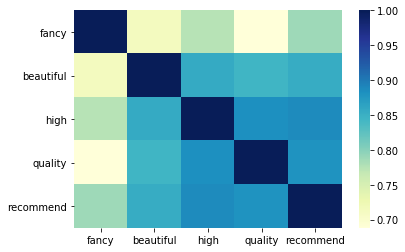

For postive reviews: 


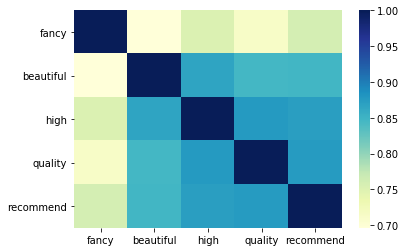

For negative reviews: 


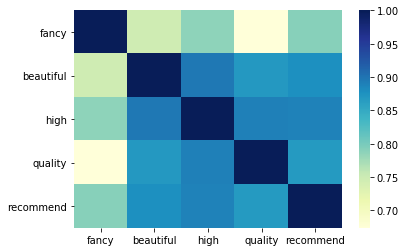

In [35]:
text = "fancy beautiful high quality recommend"
print("fancy beautiful high quality recommend")
import seaborn as sns
from scipy.spatial.distance import cosine

def word_vector(text, word_id, model, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings, sentence_embeddings = model(tokens_tensor)   
    vector = word_embeddings[0][word_id].detach().numpy()
    return vector
def visualise_diffs(text, model, tokenizer):
    word_vecs = []
    for i in range(0, len(text.split())):
        word_vecs.append(word_vector(text, i, model, tokenizer))
    L = []
    for p in word_vecs:
        l = []
        for q in word_vecs:
            l.append(1 - cosine(p, q))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(text.split()), index = list(text.split()))
    ax = sns.heatmap(div, cmap="YlGnBu")
    plt.show()

print(" ")
print("For neutral reviews: ")
visualise_diffs(text, roberta_1_model_embedding, roberta_1_tokenizer)
print("For postive reviews: ")
visualise_diffs(text, roberta_2_model_embedding, roberta_2_tokenizer)
print("For negative reviews: ")
visualise_diffs(text, roberta_3_model_embedding, roberta_3_tokenizer)

ugly uncomfortable constrained poor avoid
 
For neutral reviews: 


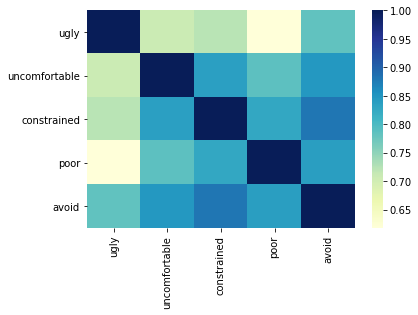

For postive reviews: 


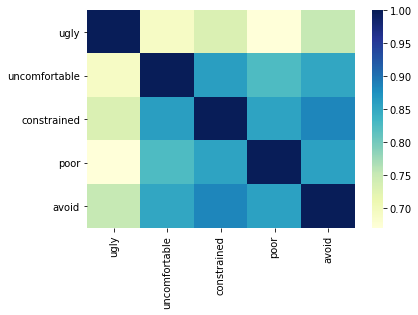

For negative reviews: 


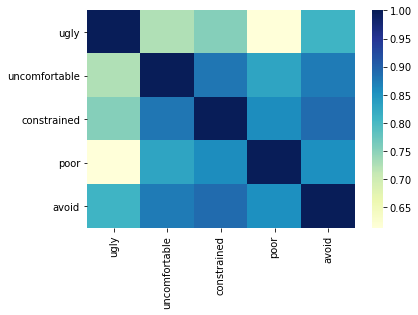

In [36]:
text = "ugly uncomfortable constrained poor avoid"
print("ugly uncomfortable constrained poor avoid")
import seaborn as sns
from scipy.spatial.distance import cosine

def word_vector(text, word_id, model, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings, sentence_embeddings = model(tokens_tensor)   
    vector = word_embeddings[0][word_id].detach().numpy()
    return vector
def visualise_diffs(text, model, tokenizer):
    word_vecs = []
    for i in range(0, len(text.split())):
        word_vecs.append(word_vector(text, i, model, tokenizer))
    L = []
    for p in word_vecs:
        l = []
        for q in word_vecs:
            l.append(1 - cosine(p, q))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(text.split()), index = list(text.split()))
    ax = sns.heatmap(div,cmap="YlGnBu")
    plt.show()

print(" ")
print("For neutral reviews: ")
visualise_diffs(text, roberta_1_model_embedding, roberta_1_tokenizer)
print("For postive reviews: ")
visualise_diffs(text, roberta_2_model_embedding, roberta_2_tokenizer)
print("For negative reviews: ")
visualise_diffs(text, roberta_3_model_embedding, roberta_3_tokenizer)

ordinary plain common usual general ecumenical
 
For neutral reviews: 


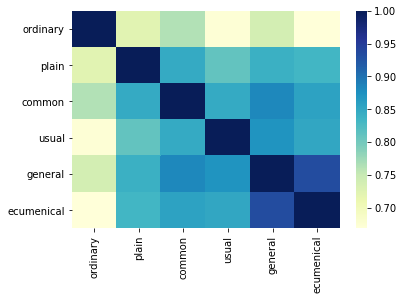

For postive reviews: 


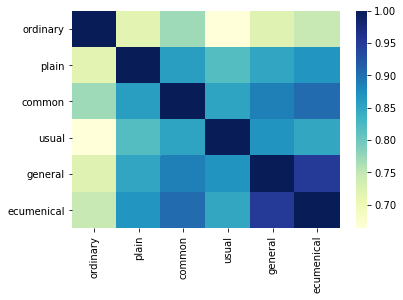

For negative reviews: 


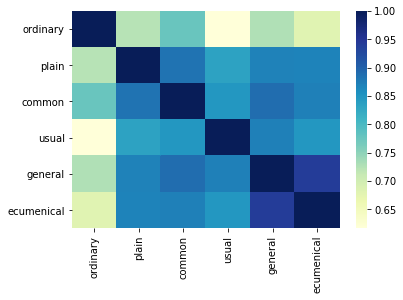

In [37]:
text = "ordinary plain common usual general ecumenical"
print("ordinary plain common usual general ecumenical")
import seaborn as sns
from scipy.spatial.distance import cosine

def word_vector(text, word_id, model, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings, sentence_embeddings = model(tokens_tensor)   
    vector = word_embeddings[0][word_id].detach().numpy()
    return vector
def visualise_diffs(text, model, tokenizer):
    word_vecs = []
    for i in range(0, len(text.split())):
        word_vecs.append(word_vector(text, i, model, tokenizer))
    L = []
    for p in word_vecs:
        l = []
        for q in word_vecs:
            l.append(1 - cosine(p, q))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(text.split()), index = list(text.split()))
    ax = sns.heatmap(div,cmap="YlGnBu")
    plt.show()

print(" ")
print("For neutral reviews: ")
visualise_diffs(text, roberta_1_model_embedding, roberta_1_tokenizer)
print("For postive reviews: ")
visualise_diffs(text, roberta_2_model_embedding, roberta_2_tokenizer)
print("For negative reviews: ")
visualise_diffs(text, roberta_3_model_embedding, roberta_3_tokenizer)